Изображение загружено успешно. Размер: (112, 1200, 3)


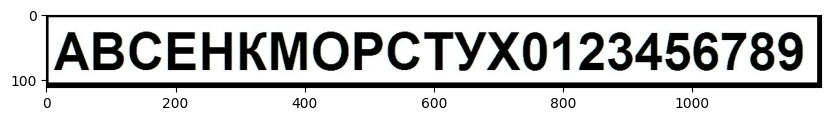

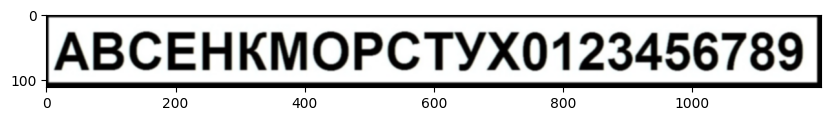

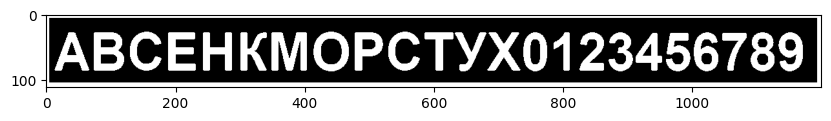

In [320]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
def imshow_rgb(img, figsize = None):
    if figsize is None:
        figsize = (10, 6)
        
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

def imshow_hsv(img):
    rgb_img = cv.cvtColor(img, cv.COLOR_HSV2RGB)
    imshow_rgb(rgb_img)

def imshow_grayscale(img):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.show()

# Проверяем существование файла
picture_files_path = './jpg/'
file1 = picture_files_path + 'dict__.jpg'

def read_binarize(file, show_additional_steps=True):
    dict_img = cv.imread(file)
        
    if dict_img is None:
        print("Ошибка загрузки изображения")
    else:
        print(f"Изображение загружено успешно. Размер: {dict_img.shape}")
        imshow_rgb(dict_img)


    if show_additional_steps:
        blurred = cv.GaussianBlur(dict_img, (5, 5), 0)
        cv.GaussianBlur(dict_img, (5,5), 0)
        imshow_rgb(blurred)

    dict_hsv = cv.blur(dict_img, (2, 2))
    dict_hsv = cv.cvtColor(dict_hsv, cv.COLOR_BGR2HSV)
    dict_mask = cv.inRange(dict_hsv, (0, 0, 0), (255, 255, 141))

    imshow_grayscale(dict_mask)

    contours, hierarchy = cv.findContours(dict_mask, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)
    return dict_img, dict_mask, contours, hierarchy

dict_img, dict_mask, contours, hierarchy = read_binarize(file1)

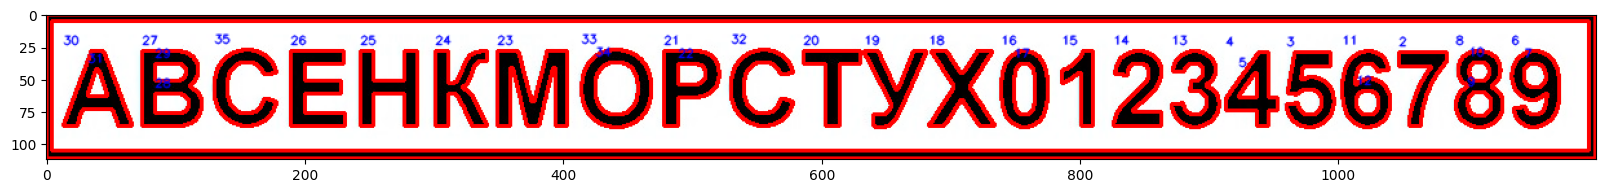

In [321]:

def show_img_with_contours(dict_img, contours):
    img = dict_img.copy()
    cv.drawContours(img, contours, -1, 255, thickness=2)
    # 11. Добавление информации о контурах
    for i, cnt in enumerate(contours):
        area = cv.contourArea(cnt)
        x, y, w, h = cv.boundingRect(cnt)
        
        if area > 100:  # Фильтрация по площади
            cv.putText(img, f'{i}', (x, y-5),
                        cv.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv.LINE_AA)

    imshow_rgb(img, figsize=(20, 12))

show_img_with_contours(dict_img, contours)

In [322]:
sample_contour_id = {
    'A': 30,
    'B': 27,
    'C': 35,
    'E': 26,
    'H': 25,
    'K': 24,
    'M': 23,
    'O': 33,
    'P': 21,
    'T': 20,
    'Y': 19,
    'X': 18,
    '0': 16,
    '1': 15,
    '2': 14,
    '3': 13,
    '4': 4,
    '5': 3,
    '6': 11,
    '7': 2,
    '8': 8,
    '9': 6
}

In [323]:
class Contour:
    def __init__(self, contour, convertFromDecart = True):
        if convertFromDecart:
            complex_contour = self.decartToComplex(contour)
        else:
            complex_contour = contour

        self._set_countour(complex_contour)

    def _set_countour(self, contour):
        self.contour = contour
        self._contour_length = self._get_contour_length()

    @staticmethod
    def tuple_to_complex(point: tuple) -> complex:
        return complex(point[0][0], point[0][1])
    
    @staticmethod
    def multiplyCVectors(a: np.array, b: np.array) -> np.array:
        return a.T @ b.conjugate()
    
    def multiplyTo(self, other: "Contour") -> np.array:
        return Contour.multiplyCVectors(self.contour, other)

    @staticmethod
    def calc_contour_length(c: np.array):
        return np.sum(np.sqrt(c * c.conjugate()))
    
    def _get_contour_length(self):
        return Contour.calc_contour_length(self.contour)
    
    def contour_length(self):
        return self._contour_length
    
    @staticmethod
    def VKF(contour1: "Contour",contour2: "Contour"):
        c1: np.array = contour1.contour
        c2: np.array = contour2.contour

        res = []
        for k in range(c1.shape[0]):
            c2_roll = np.roll(c2, -k)
            res.append(Contour.multiplyCVectors(c1, c2_roll))
        
        return np.array(res)

    @staticmethod
    def contours_similarity(cont1: "Contour", cont2: "Contour"):
        vkf = Contour.VKF(cont1, cont2)
        similarity = np.max(np.abs(vkf)) / np.sqrt(cont1.contour_length().real * cont2.contour_length().real)

        return similarity

    def decartToComplex(self, contour):
        compl_contour = [ ]
        last_point = Contour.tuple_to_complex(contour[0])
        for i, point_tuple in enumerate(contour):
            if i == 0:
                continue

            point = Contour.tuple_to_complex(point_tuple)
            compl_contour.append(point - last_point)
            last_point = point

        return np.array(compl_contour)


    def equalize(self, p, log=False):
        eqvec = [complex(0,0)] * p
        eq_len = self.contour_length() / p
        if log:
            print(eq_len)
        pind = 0

        def calc_norm(vec):
            if not isinstance(vec, np.ndarray):
                vec = np.array(vec)
                return np.sqrt(vec * vec.conjugate())
                
            return np.sqrt(vec.T @ vec.conjugate())

        vec = self.contour
        vec_ost = vec[0]
        vec_isp = complex(0,0)
        j = 0
        while pind < p - 1:
            vlen = calc_norm(vec_ost)
            if vlen > eq_len:
                eqvec[pind] = vec_ost * eq_len / vlen
                vec_ost = vec_ost - eqvec[pind]
                if log:
                    print('f: ' + str(pind) + '   ' + str(eqvec[pind]))
                pind += 1
            else:
                s = calc_norm(vec_ost)

                for t in range(j + 1, len(vec)):
                    s0 = s

                    s = s + calc_norm(vec[t])


                    if (s > eq_len):
                        vec_isp_len = eq_len - s0
                        vec_isp = vec[t] * vec_isp_len / calc_norm(vec[t])

                        vecs = complex(0,0)
                        for tt in range(j+1, t - 1):
                            vecs = vecs + vec[tt]


                        eqvec[pind]= vec_ost + vec_isp + vecs
                        vec_ost = vec[t] - vec_isp

                        if log:
                            print(str(pind) + '   ' + str(eqvec[pind]))

                        pind += 1
                        j = t
                        break

                if pind >= p - 1:   

                    
                    eqvec[pind] = -sum(eqvec)

                    if log:
                        print(str(pind) + '   ' + str(eqvec[pind]))
                    pind += 1
                    break
            if pind >= p  :
                break
                
        return Contour(np.array(eqvec), convertFromDecart=False)

In [324]:
sample_contours = dict()
for character, id in sample_contour_id.items():
    sample_contours[character] = Contour(contours[id])

In [325]:
def calc_similaritites(contour: np.array, equalize_to: int=None):
    cont = Contour(contour)
    
    similarities = dict()
    if equalize_to is None:
        equalize_to = cont.contour.shape[0]
    else:
        cont = cont.equalize(equalize_to)

    for character, sample_contour in sample_contours.items():
        # if sample_contour.contour.shape[0] != equalize_to:
        equalized_sample_contour = sample_contour.equalize(equalize_to)
        # else:
        #     equalized_sample_contour = sample_contour

        similarity = Contour.contours_similarity(cont, equalized_sample_contour)
        similarities[character] = similarity

    return similarities

print(calc_similaritites(contours[30]))

{'A': 0.9596844075440187, 'B': 0.6979774446842472, 'C': 0.5857501751972753, 'E': 0.509595276879052, 'H': 0.5556736163724406, 'K': 0.5400770606343404, 'M': 0.43329021842729737, 'O': 0.7055957139274244, 'P': 0.8467466088835307, 'T': 0.6949251006073961, 'Y': 0.8930950574993187, 'X': 0.5321773665710632, '0': 0.6417459617200614, '1': 0.6441291514590709, '2': 0.5317020492598328, '3': 0.514431358753447, '4': 0.7032907737972657, '5': 0.42685872470924663, '6': 0.6127935044821262, '7': 0.6414673233337043, '8': 0.6497792376359746, '9': 0.6262079741287235}


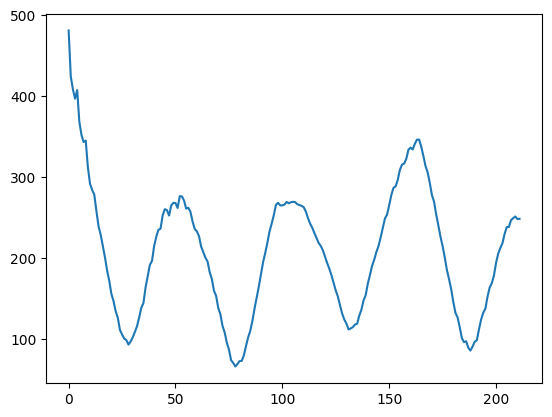

(448.19595949289334+0j)


In [326]:


test_countour = Contour(contours[23])
vkf = Contour.VKF(test_countour, test_countour)
m = vkf.shape[0]
plt.plot(np.abs(vkf[:int(m/2)]))
plt.show()

print(test_countour.contour_length())

In [327]:
contours[0][0][0][0]

0

Изображение загружено успешно. Размер: (297, 1200, 3)


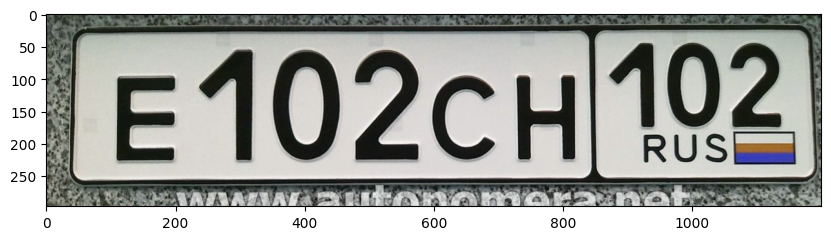

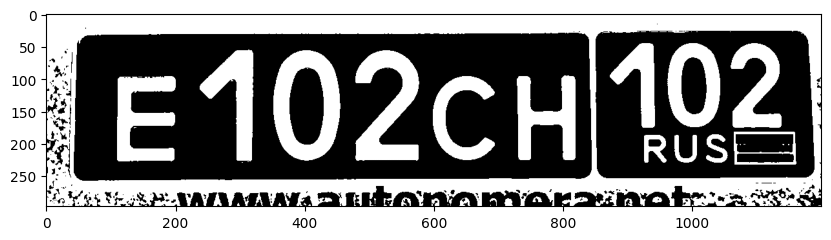

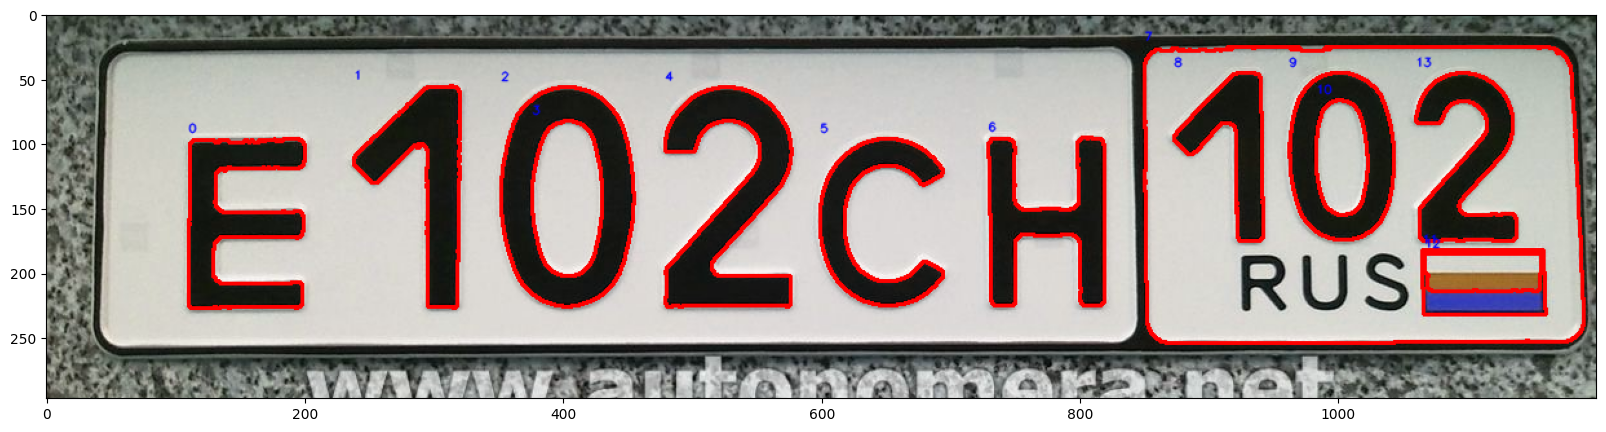

Контур   0 наиболее похож на   E со схожестью  0.63
Контур   1 наиболее похож на   7 со схожестью  0.57
Контур   2 наиболее похож на   O со схожестью  0.64
Контур   4 наиболее похож на   2 со схожестью  0.63
Контур   5 наиболее похож на   C со схожестью  0.74
Контур   6 наиболее похож на   H со схожестью  0.67
Контур   8 наиболее похож на   7 со схожестью  0.68
Контур   9 наиболее похож на   O со схожестью  0.74
Контур  11 наиболее похож на   B со схожестью  0.75
Контур  13 наиболее похож на   2 со схожестью  0.72

Получили номер E7O2CH
Чтение и предобратотка изображения: 201мс
Отсев лишних контуров и сортировка по координатам: 11мс
Отрисовка контуров на изображении: 194мс
Классификация контуров: 1562мс


In [328]:
from time import perf_counter

to_open = picture_files_path + 'n11.jpg'

start_time = perf_counter()
dict_img, dict_mask, contours, hierarchy = read_binarize(to_open, show_additional_steps=False)
predobr_end_time = perf_counter()

filtered_contours = []
min_area = 1500
max_perimeter = 2000
for i, contour in enumerate(contours):
    area = cv.contourArea(contour)
    contour_length = Contour(contour).contour_length()
    if area > min_area and contour_length < max_perimeter:
        filtered_contours.append(contour)

def first_point_x(item):
    return item[0][0][0]

filtered_contours = list(sorted(filtered_contours, key=first_point_x))

contours_predobr_end_time = perf_counter()
show_img_with_contours(dict_img, filtered_contours)
contours_draw_end_time = perf_counter()

number = ''
for i, contour in enumerate(filtered_contours):
    similarities = calc_similaritites(contour)
    character, max_similarity = max(similarities.items(), key=lambda x: x[1])
    if max_similarity < 0.5:
        continue

    if len(number) < 6:
        number += character
    print(f'Контур {i:>3} наиболее похож на {character:>3} со схожестью {max_similarity:>5.2f}')
classify_end_time = perf_counter()


print(f'\nПолучили номер {number}')
print(f'Чтение и предобратотка изображения: {(predobr_end_time - start_time)*1000:.0f}мс')
print(f'Отсев лишних контуров и сортировка по координатам: {(contours_predobr_end_time - predobr_end_time)*1000:.0f}мс')
print(f'Отрисовка контуров на изображении: {(contours_draw_end_time - contours_predobr_end_time)*1000:.0f}мс')
print(f'Классификация контуров: {(classify_end_time - contours_draw_end_time)*1000:.0f}мс')

In [329]:
print(len(contours))
print(contours[0])
print(len(contours[0]))
print(contours[0][1])


242
[[[1196  296]]

 [[1197  296]]

 [[1198  296]]

 [[1199  296]]

 [[1198  296]]

 [[1197  296]]]
6
[[1197  296]]
